<a href="https://colab.research.google.com/github/Aaron-Cunningham/Data-Science_Machine-Learning_Computer-Vision/blob/main/Computer_Vision_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final coursework part 3

## Loading in the data

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using GPU, device name: NVIDIA GeForce RTX 3080 Ti


## Importing the data and pre-processing

In [32]:
batch_size = 64
# pipelines the transform
# Transformations sourced from [https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde]
transform = transforms.Compose([
                               transforms.RandomHorizontalFlip(p=0.4),
                               transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalises the pixel values between [-1, 1]
                               ])

# Downloads training and test CIFAR10 data
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)
# Split the training data into two sets: Validation and training
train_data, valid_data = random_split(train_data,[45000,5000])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

print('Number of training examples/images in the training dataset.     : ',len(train_loader.dataset))
print('Number of validation examples/images in the validation dataset  : ',len(valid_loader.dataset))
print('Number of validation examples/images in the test dataset        : ',len(test_loader.dataset))
print('batch size                                                      : ',batch_size)





Files already downloaded and verified
Files already downloaded and verified
Number of training examples/images in the training dataset.     :  45000
Number of validation examples/images in the validation dataset  :  5000
Number of validation examples/images in the test dataset        :  10000
batch size                                                      :  64


## Architecture setup

### VGG-16 with BN

In [33]:
# Architecture referenced and adapted from [https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55]
class Vgg16_Net_BN(nn.Module):
    def __init__(self, num_classes):
        super(Vgg16_Net_BN, self).__init__()
        # Conv 1
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 2
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 3
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 4
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 5
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layer 1
        self.fc_layer1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        # Fully connected layer 2
        self.fc_layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )

        # Fully connected layer 3
        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    # Forward pass through all convultional layers
    def forward(self, x):
      x = self.conv_layer1(x)
      x = self.conv_layer2(x)
      x = self.conv_layer3(x)
      x = self.conv_layer4(x)
      x = self.conv_layer5(x)
      # Flatten
      x = x.reshape(x.size(0), -1)
      x = self.fc_layer1(x)
      x = self.fc_layer2(x)
      x = self.fc_layer3(x)
      return x

### VGG-16 without batch normalisation

In [34]:
# Architecture referenced and adapted from [https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55]
class Vgg16_Net(nn.Module):
    def __init__(self, num_classes):
        super(Vgg16_Net, self).__init__()
        # Conv 1
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Conv 2
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 3
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 4
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv 5
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layer 1
        self.fc_layer1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        # Fully connected layer 2
        self.fc_layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        # Fully connected layer 3
        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )
    # Forward pass through all convultional layers
    def forward(self, x):
      x = self.conv_layer1(x)
      x = self.conv_layer2(x)
      x = self.conv_layer3(x)
      x = self.conv_layer4(x)
      x = self.conv_layer5(x)
      # Flatten
      x = x.reshape(x.size(0), -1)
      x = self.fc_layer1(x)
      x = self.fc_layer2(x)
      x = self.fc_layer3(x)
      return x

## Count correct function

In [35]:
# Code sourced from [https://colab.research.google.com/drive/1gnAqRjmEf4qxc_UjRqXUE9pJxIEmShmh]
def correct(output, target):
    predicted_class = output.argmax(1)                          # pick class with largest network output
    prediction = (predicted_class == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return prediction.sum().item()                              # count number of correct classification/prediction

## Testing function

In [36]:
# Code sourced from [https://colab.research.google.com/drive/1gnAqRjmEf4qxc_UjRqXUE9pJxIEmShmh]
def test(test_loader, model, lossfunt):
    num_examples = len(test_loader.dataset)
    num_batches = len(test_loader)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = lossfunt(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_examples

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

## Training function

In [37]:
# Code adapted from [https://colab.research.google.com/drive/1gnAqRjmEf4qxc_UjRqXUE9pJxIEmShmh]
def train(train_loader, valid_loader, model, lossfunt, optimizer, epoch, patience, best_valid_loss, patience_counter, batch_normalisation):
    model.train()

    num_examples = len(train_loader.dataset)
    num_batches = len(train_loader)

    total_loss = 0
    total_correct = 0
    epoch_early_stop = 0

    for train_data, target in train_loader:
        # Copy data and targets to GPU
        data = train_data.to(device)
        target = target.to(device)

        # Do a forward pass
        output = model(data)

        # Calculate the loss
        loss = lossfunt(output, target)
        total_loss += loss.item()

        # Count number correct
        total_correct += correct(output, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate training accuracy and loss
    train_loss = total_loss/num_batches
    train_accuracy = total_correct/num_examples

    # Validation code adapted from [https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/]
    total_valid_loss = 0
    total_valid_correct = 0
    num_valid_batches = len(valid_loader)
    num_valid_examples = len(valid_loader.dataset)
    model.eval()

    for val_data, target in valid_loader:
      # Copy data and targets to GPU
      data = val_data.to(device)
      target = target.to(device)

      # Do a forward pass
      output = model(data)

      # Calculate the loss
      loss = lossfunt(output, target)
      total_valid_loss += loss.item()

      # Count number correct
      total_valid_correct += correct(output, target)

    # Calculate Validation accuracy and loss
    valid_loss = total_valid_loss/num_valid_batches
    valid_accuracy = total_valid_correct/num_valid_examples

    print(f"Train Loss       = {train_loss:.6f},  Train Accuracy        = {train_accuracy:.2%}, ")
    print(f"Valdation Loss   = {valid_loss:.6f},  Validation Accuracy   = {valid_accuracy:.2%}")


    # Early Stopping
    if valid_loss < best_valid_loss:
      # Update the best
      best_valid_loss = valid_loss
      # Update the for current best
      epoch_early_stop = epoch
      # Reset the patience counter
      patience_counter = 0
      # Save the model method sourced from [https://pytorch.org/tutorials/beginner/saving_loading_models.html]
      if batch_normalisation:
        torch.save(model.state_dict(), 'with_bn_best_model.pth')
      else:
        torch.save(model.state_dict(), 'without_bn_best_model.pth')
      print("Saving model")
    # No improvement-increase the patience counter
    else:
      patience_counter += 1
      print(f"Patience: {patience_counter}/{patience}")





    return[train_loss, train_accuracy, valid_loss, valid_accuracy, best_valid_loss, patience_counter, epoch_early_stop]
    print(f"Average loss: {train_loss:7f}, accuracy: {train_accuracy:.2%}")

## Model initilisation

In [38]:
# Modal with batch normalisation
model_with_bn = Vgg16_Net_BN(num_classes=10).to(device)
# Modal without batch normalisation
model_without_bn = Vgg16_Net(num_classes=10).to(device)
print(model_with_bn)
print('-' * 80)
print(model_without_bn)

Vgg16_Net_BN(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(

## Training loop

In [39]:
# Code adapted from [https://colab.research.google.com/drive/1gnAqRjmEf4qxc_UjRqXUE9pJxIEmShmh#scrollTo=UysGvg_s7e4w]
patience = 5
best_valid_loss = float('inf')
lossfunt = nn.CrossEntropyLoss()
num_epochs=50
patience_counter = 0
learning_rate = 0.001
optimiser_without_bn = torch.optim.Adam(model_without_bn.parameters(), lr=learning_rate)
optimiser_with_bn = torch.optim.Adam(model_with_bn.parameters(), lr=learning_rate)


def train_loop(train_loader, valid_loader, model, lossfunt, optimizer, patience, best_valid_loss, history, num_epochs, batch_normalisation=False):
  patience_counter = 0
  for epoch in range(num_epochs):
      print(f"Training epoch: {epoch + 1}")
      train_loss, train_accuracy, valid_loss, valid_accuracy, best_valid_loss, patience_counter, epoch_early_stop = train(train_loader, valid_loader, model, lossfunt,
                                                                                                                          optimizer, epoch, patience, best_valid_loss, patience_counter,
                                                                                                                          batch_normalisation)


      history.append((train_loss, train_accuracy, valid_loss, valid_accuracy, epoch_early_stop))
      if patience_counter >= patience:
          print("Early stopping")
          break

  best_model = max(h[4] for h in history)

  print('-' * 30)
  print(f'Model at epoch {best_model + 1} was saved')
  print('-' * 30)




## Training without batch normalisation

In [40]:
history_without_bn = []
train_loop(train_loader, valid_loader, model_without_bn, lossfunt, optimiser_without_bn, patience, best_valid_loss, history_without_bn, num_epochs, batch_normalisation=False)

Training epoch: 1
Train Loss       = 2.281333,  Train Accuracy        = 11.05%, 
Valdation Loss   = 1.995733,  Validation Accuracy   = 20.58%
Saving model
Training epoch: 2
Train Loss       = 1.925614,  Train Accuracy        = 20.71%, 
Valdation Loss   = 1.873513,  Validation Accuracy   = 23.76%
Saving model
Training epoch: 3
Train Loss       = 1.850250,  Train Accuracy        = 24.48%, 
Valdation Loss   = 1.779291,  Validation Accuracy   = 27.78%
Saving model
Training epoch: 4
Train Loss       = 1.730578,  Train Accuracy        = 32.04%, 
Valdation Loss   = 1.629282,  Validation Accuracy   = 37.64%
Saving model
Training epoch: 5
Train Loss       = 1.561582,  Train Accuracy        = 40.71%, 
Valdation Loss   = 1.466576,  Validation Accuracy   = 44.46%
Saving model
Training epoch: 6
Train Loss       = 1.424825,  Train Accuracy        = 47.16%, 
Valdation Loss   = 1.359988,  Validation Accuracy   = 50.30%
Saving model
Training epoch: 7
Train Loss       = 1.347604,  Train Accuracy        

In [41]:
import torch

# Load the model [https://pytorch.org/tutorials/beginner/saving_loading_models.html]
model_without_bn.load_state_dict(torch.load('without_bn_best_model.pth'))
model_without_bn.eval()

# Shows test accuracy for model without batch normalisation
test(test_loader, model_without_bn, lossfunt)


C:\Users\Aaron\AppData\Local\Temp\ipykernel_17756\463766548.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_bn.load_state_dict(torch.load('without_bn_best_

Testset accuracy: 72.0%, average loss: 0.882734


## Training with batch normalisation

In [42]:
history_with_bn = []
train_loop(train_loader, valid_loader, model_with_bn, lossfunt, optimiser_with_bn, patience, best_valid_loss, history_with_bn, num_epochs, batch_normalisation=True)

Training epoch: 1
Train Loss       = 1.972591,  Train Accuracy        = 20.34%, 
Valdation Loss   = 1.719241,  Validation Accuracy   = 30.08%
Saving model
Training epoch: 2
Train Loss       = 1.599200,  Train Accuracy        = 35.50%, 
Valdation Loss   = 1.475460,  Validation Accuracy   = 40.32%
Saving model
Training epoch: 3
Train Loss       = 1.353498,  Train Accuracy        = 48.73%, 
Valdation Loss   = 1.214120,  Validation Accuracy   = 58.06%
Saving model
Training epoch: 4
Train Loss       = 1.102768,  Train Accuracy        = 61.24%, 
Valdation Loss   = 1.021760,  Validation Accuracy   = 64.54%
Saving model
Training epoch: 5
Train Loss       = 0.967977,  Train Accuracy        = 66.88%, 
Valdation Loss   = 0.870272,  Validation Accuracy   = 68.66%
Saving model
Training epoch: 6
Train Loss       = 0.858651,  Train Accuracy        = 71.29%, 
Valdation Loss   = 0.796464,  Validation Accuracy   = 73.34%
Saving model
Training epoch: 7
Train Loss       = 0.778167,  Train Accuracy        

In [43]:
# Loads best model saved during early stopping
model_with_bn.load_state_dict(torch.load('with_bn_best_model.pth'))
model_without_bn.eval()
# Shows test accuracy for model with batch normalisation
test(test_loader, model_with_bn, lossfunt)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17756\1726222341.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_bn.load_state_dict(torch.load('with_bn_best_model

Testset accuracy: 86.9%, average loss: 0.427356


## Early stopping visualisation

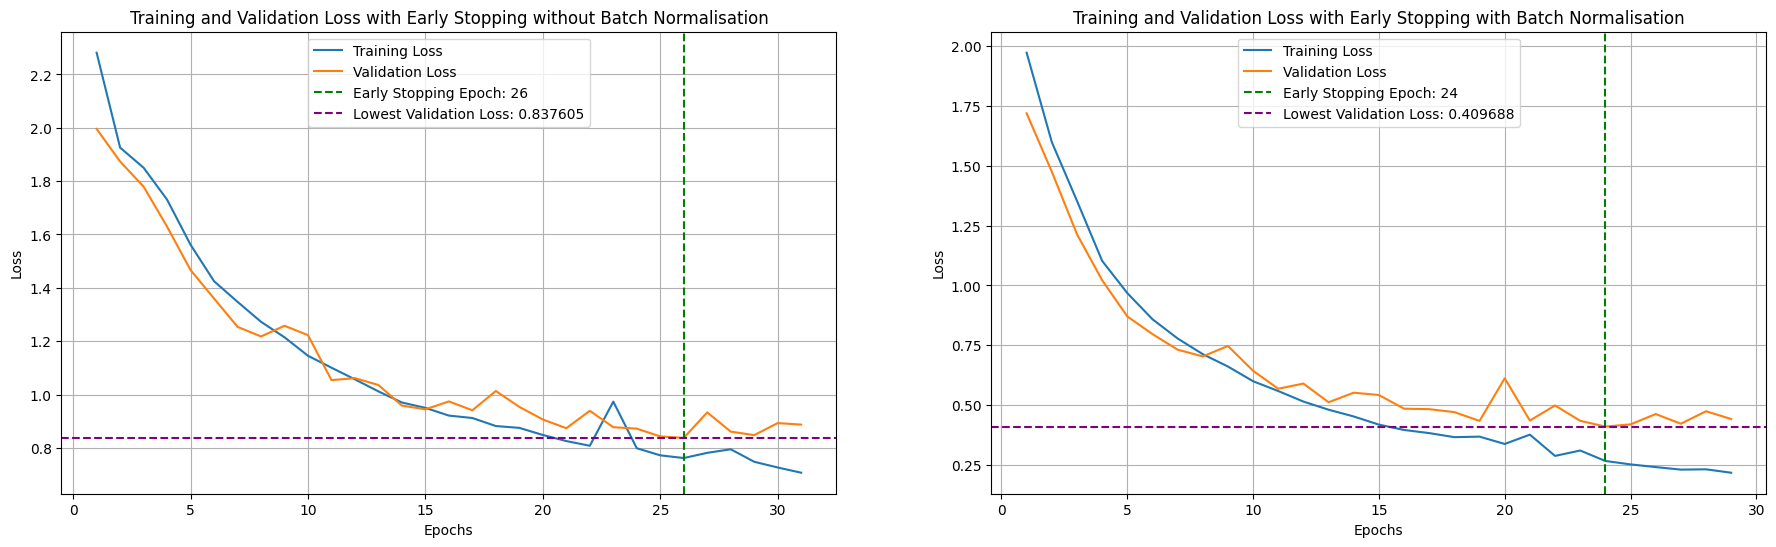

<Figure size 1000x600 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(22, 6))
# extracts training and validation loss, and early stopping point from the history without bn
train_losses_without_bn = [history[0] for history in history_without_bn]
valid_losses_without_bn = [history[2] for history in history_without_bn]
epoch_early_stop_without_bn = max(history[4] for history in history_without_bn)
min_valid_loss_without_bn = min(valid_losses_without_bn)

epochs = range(1, len(history_without_bn) + 1)


# plot training and validation loss
plt.figure(figsize=(10, 6))
axes[0].plot(epochs, train_losses_without_bn, label='Training Loss')
axes[0].plot(epochs, valid_losses_without_bn, label='Validation Loss')

# marks the early stopping point
axes[0].axvline(x=epoch_early_stop_without_bn + 1, color='g', linestyle='--', label=f'Early Stopping Epoch: {epoch_early_stop_without_bn + 1}')

# marks the lowest validation
axes[0].axhline(y=min_valid_loss_without_bn, color='purple', linestyle='--', label=f'Lowest Validation Loss: {min_valid_loss_without_bn:.6f}')

# sets the title, x label, y label, legend, and grid
axes[0].set_title("Training and Validation Loss with Early Stopping without Batch Normalisation")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()


# extracts training and validation loss, and early stopping point from the history with bn
train_losses_with_bn = [history[0] for history in history_with_bn]
valid_losses_with_bn = [history[2] for history in history_with_bn]
epoch_early_stop_with_bn = max(history[4] for history in history_with_bn)
# finds the minimum validation loss
min_valid_loss_with_bn = min(valid_losses_with_bn)

epochs_bn = range(1, len(history_with_bn) + 1)

# plot training and validation loss
axes[1].plot(epochs_bn, train_losses_with_bn, label='Training Loss')
axes[1].plot(epochs_bn, valid_losses_with_bn, label='Validation Loss')

# marks the early stopping point
axes[1].axvline(x=epoch_early_stop_with_bn + 1, color='g', linestyle='--', label=f'Early Stopping Epoch: {epoch_early_stop_with_bn + 1}')

# marks the lowest validation
axes[1].axhline(y=min_valid_loss_with_bn, color='purple', linestyle='--', label=f'Lowest Validation Loss: {min_valid_loss_with_bn:.6f}')

# sets the title, x label, y label, legend, and grid
axes[1].set_title("Training and Validation Loss with Early Stopping with Batch Normalisation")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()



## Convergence graph comparing loss with/without btach normalisation

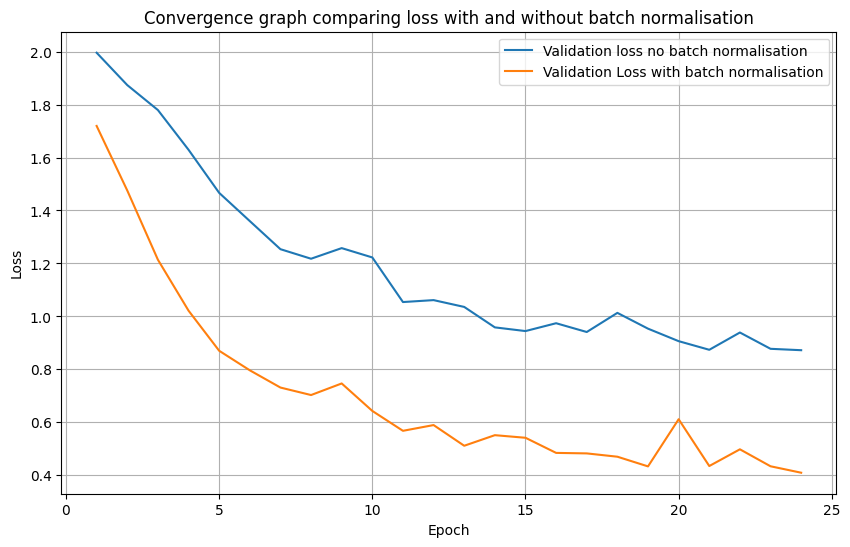

In [45]:
# takes the first 30 values from validation loss from model with and without batch normalisation
first_24_valid_loss = valid_losses_without_bn[:24]
first_24_valid_loss_bn = valid_losses_with_bn[:24]
# Limits the amount of epochs between 1 and 30
epochs = list(range(1, 25))

plt.figure(figsize=(10, 6))
# plots the loss without batch normalisation
plt.plot(epochs, first_24_valid_loss, label='Validation loss no batch normalisation')
# Plots the loss with batch normalisation
plt.plot(epochs, first_24_valid_loss_bn, label='Validation Loss with batch normalisation')
plt.title('Convergence graph comparing loss with and without batch normalisation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


## Visualising Filters first convolutional layer

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17756\3704909580.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_bn.load_state_dict(torch.load('with_bn_best_model

First convolutional layer:          Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Filter values from first filter: tensor([[[ 0.2905,  0.3871,  0.1410],
         [ 0.0994,  0.1384, -0.0655],
         [ 0.0540,  0.1126, -0.0408]],

        [[ 0.0217, -0.1237,  0.2099],
         [-0.2969, -0.2314,  0.0355],
         [-0.1935,  0.1793, -0.0904]],

        [[-0.1884,  0.0774,  0.0386],
         [-0.0423, -0.1854, -0.0403],
         [-0.1118,  0.1582,  0.2094]]])

 Shape: torch.Size([64, 3, 3, 3])




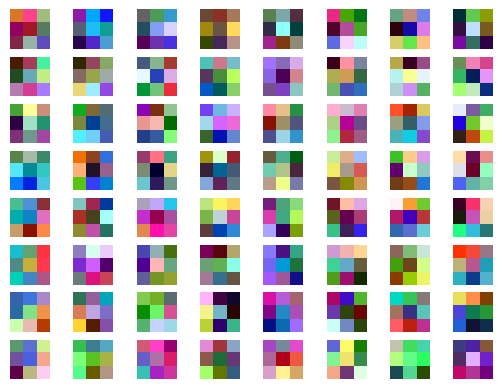

In [46]:
# Code adapted from [https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch]
# Load the model with trained filters
model_with_bn.load_state_dict(torch.load('with_bn_best_model.pth'))
conv_layer1 = model_with_bn.conv_layer1[0]
print(f"First convolutional layer:          {conv_layer1}")
# Accessing the filter weights
filters_with_bn = conv_layer1.weight.data.cpu()
print(f"Filter values from first filter: {filters_with_bn[0]}\n\n Shape: {filters_with_bn.shape}\n\n")

for i in range(len(filters_with_bn)):
  image = filters_with_bn[i]
  image = np.transpose(image, (1, 2, 0)) # Convert from Channel x Height x Width ---> Height x Width x Channel
  image = (image - image.min()) / (image.max() - image.min()) # Apply min/max normalisation on filter values (All values now between [0,1])
  plt.subplot(8, 8, i+1) # 8 Rows, 8 Columns, 64 images in total
  plt.imshow(image, cmap='grey')


  plt.axis('off')
plt.show()





##Visualising filters applied to an image

C:\Users\Aaron\AppData\Local\Temp\ipykernel_17756\1007153791.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_with_bn.load_state_dict(torch.load('with_bn_best_mode

torch.Size([1, 3, 224, 224])

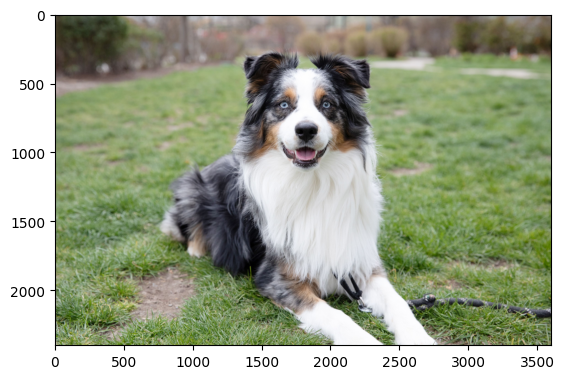

In [47]:
from PIL import Image
# Loads the test image and prints its shape
test_image = Image.open(str('dog.jpg')) # Image source [https://www.thesprucepets.com/cute-dog-breeds-we-can-t-get-enough-of-4589340]
plt.imshow(test_image)


# transformation config for the test image
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Transform the test image
test_image = transform(test_image)
# adds a batch dimension
test_image = test_image.unsqueeze(0)
# loads the pretrained model
model_with_bn.load_state_dict(torch.load('with_bn_best_model.pth'))

# checks to see if batch dimension is added
test_image.shape

Total convolutional layers: 13


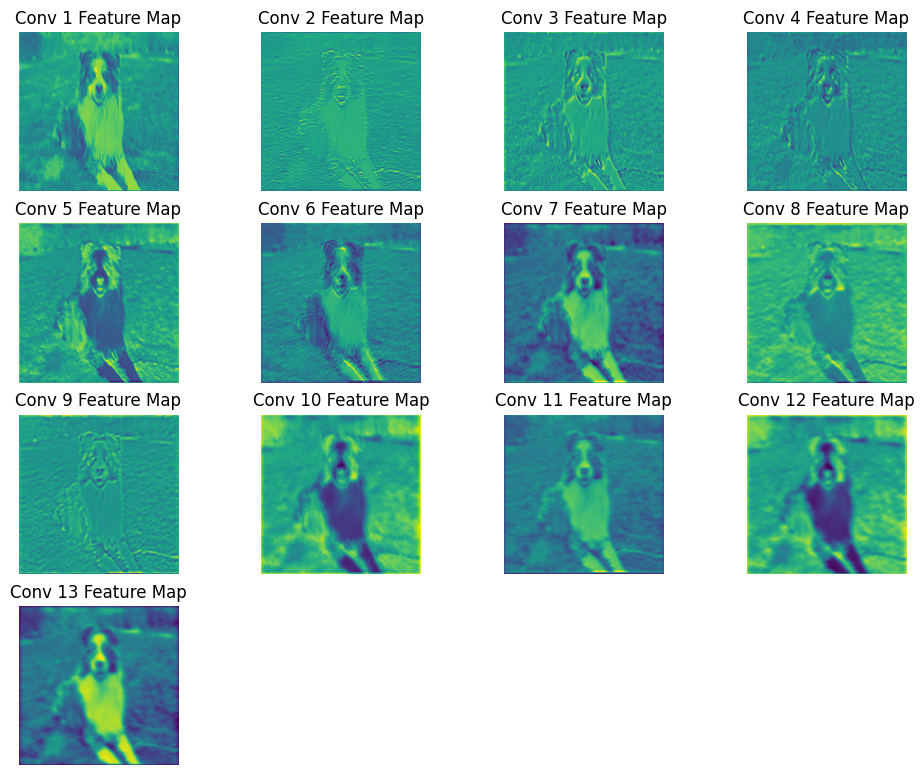

In [48]:
# Code adapted from [https://www.geeksforgeeks.org/visualizing-feature-maps-using-pytorch/]
conv_layers = []
total_conv_layers = 0

for module in model_with_bn.modules():
    if isinstance(module, nn.Conv2d): # this ensures only convolutional layers are saved
        conv_layers.append(module) # saves the layer
        total_conv_layers += 1
# Prints the total layers
print(f"Total convolutional layers: {total_conv_layers}")


feature_maps = []
test_image = test_image.to(device)

for layer in conv_layers:
  test_image = layer(test_image) # test image is passed through the layers (forward pass)
  feature_maps.append(test_image) # saves the output from the layer

processed_feature_maps = []

for feature_map in feature_maps:
  feature_map.squeeze_(0) # removes the batch size from feature map
  processed_feature_maps.append(feature_map[0].data.cpu().numpy()) # saves the first feature map from each convolutional layer and converts to numpy array

fig = plt.figure(figsize=(12, 12))
for i in range(total_conv_layers):
    ax = fig.add_subplot(5, 4, i + 1)
    ax.imshow(processed_feature_maps[i])
    ax.axis('off')
    ax.set_title(f"Conv {i+1} Feature Map")

